In [15]:
from koopman_probabilistic import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [33]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
# x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"], all_data["ISONE CA"]["DewPnt"], all_data["ISONE CA"]["DryBulb"]], dtype=np.float64))
x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"]], dtype=np.float64))

In [34]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)

In [4]:
data_name = "isone"

predict_through = 24 * (365 + 31)
train_through = -1 * 365 * 24
train_start = -2 * 365 * 24
x = x[train_start:]
xt = x[:train_through, :]

num_freqs = [5, 5, 5]
num_fourier = 3
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"

In [7]:
model = SkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier)
k.find_fourier_omegas(xt, hard_code=[24, 168, 365 * 24])

tensor([0.2618, 0.0374, 0.0007])

In [8]:
k.fit(xt, iterations=100, interval=10, verbose=True, cutoff=61, weight_decay=1e-1000, lr_theta=5e-3, lr_omega=1e-8)

Setting 3 to 46719.777777777774
Setting 4 to 2.0001331906290876
Setting 8 to 3.999980974124809
Setting 9 to 2.086910342534252
Setting 13 to 840955.9999999999
Setting 14 to 2.0
Iteration  0
tensor([2.4000e+01, 1.6800e+02, 8.7600e+03, 4.6720e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7600e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7600e+03, 8.4096e+05, 2.0000e+00])
Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7600e+03, 4.6720e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7600e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7600e+03, 8.4096e+05, 2.0000e+00], grad_fn=<MulBackward0>)
Loss:  7.208342599597395
Iteration  1
tensor([2.4000e+01, 1.6800e+02, 8.7600e+03, 4.6720e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7600e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7600e+03, 8.4096e+05, 2.0000e+00])
Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7600e+03, 4.6720e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+

Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7609e+03, 4.6685e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7602e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7602e+03, 8.4172e+05, 2.0000e+00], grad_fn=<MulBackward0>)
Loss:  -1.0991708486709988
Iteration  17
tensor([2.4000e+01, 1.6800e+02, 8.7609e+03, 4.6685e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7602e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7602e+03, 8.4172e+05, 2.0000e+00])
Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7610e+03, 4.6686e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7602e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7602e+03, 8.4177e+05, 2.0000e+00], grad_fn=<MulBackward0>)
Loss:  -1.1070035639939337
Iteration  18
tensor([2.4000e+01, 1.6800e+02, 8.7610e+03, 4.6686e+04, 2.0001e+00, 2.4000e+01,
        1.6800e+02, 8.7602e+03, 4.0000e+00, 2.0869e+00, 2.4000e+01, 1.6800e+02,
        8.7602e+03, 8.4177e+05, 2.0000e+00])
Setting peri

Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7620e+03, 1.2013e+05, 1.6822e+05, 2.4000e+01,
        1.6800e+02, 8.7607e+03, 2.0004e+00, 1.0645e+04, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 2.1009e+05, 2.0000e+00], grad_fn=<MulBackward0>)
Loss:  -1.107668961873156
Iteration  33
tensor([2.4000e+01, 1.6800e+02, 8.7620e+03, 1.2013e+05, 1.6822e+05, 2.4000e+01,
        1.6800e+02, 8.7607e+03, 2.0004e+00, 1.0645e+04, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 2.1009e+05, 2.0000e+00])
Setting periods to tensor([2.4000e+01, 1.6800e+02, 8.7622e+03, 1.2013e+05, 1.6822e+05, 2.4000e+01,
        1.6801e+02, 8.7608e+03, 2.0004e+00, 1.0645e+04, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 2.1004e+05, 2.0000e+00], grad_fn=<MulBackward0>)
Loss:  -1.1211937282999516
Iteration  34
tensor([2.4000e+01, 1.6800e+02, 8.7622e+03, 1.2013e+05, 1.6822e+05, 2.4000e+01,
        1.6801e+02, 8.7608e+03, 2.0004e+00, 1.0645e+04, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 2.1004e+05, 2.0000e+00])
Setting perio

Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7633e+03, 2.0001e+00, 8.0000e+00, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 4.0000e+00, 2.0004e+00, 2.4000e+01, 1.6800e+02,
        8.7607e+03, 8.4081e+05, 4.0000e+00], grad_fn=<MulBackward0>)
Loss:  -1.1934624670325076
Setting 3 to 2.0000998913087424
Setting 4 to 9893.599999999999
Setting 8 to 9778.558139534884
Setting 9 to 9666.160919540229
Setting 13 to 420477.99999999994
Setting 14 to 840955.9999999999
Iteration  50
tensor([2.4000e+01, 1.6801e+02, 8.7633e+03, 2.0001e+00, 9.8936e+03, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 9.7786e+03, 9.6662e+03, 2.4000e+01, 1.6800e+02,
        8.7607e+03, 4.2048e+05, 8.4096e+05])
Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7633e+03, 2.0001e+00, 9.8936e+03, 2.4000e+01,
        1.6801e+02, 8.7614e+03, 9.7786e+03, 9.6662e+03, 2.4000e+01, 1.6800e+02,
        8.7607e+03, 4.2044e+05, 8.4094e+05], grad_fn=<MulBackward0>)
Loss:  -1.1603644888494835
Iteration  51
tensor([2.4000e+01, 1.6801e

Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7631e+03, 2.0003e+00, 9.7788e+03, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 2.0004e+00, 9.8935e+03, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 8.4048e+05, 2.0873e+00], grad_fn=<MulBackward0>)
Loss:  -1.1744999555008597
Iteration  66
tensor([2.4000e+01, 1.6801e+02, 8.7631e+03, 2.0003e+00, 9.7788e+03, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 2.0004e+00, 9.8935e+03, 2.4000e+01, 1.6800e+02,
        8.7606e+03, 8.4048e+05, 2.0873e+00])
Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7631e+03, 2.0003e+00, 9.7788e+03, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 2.0004e+00, 9.8935e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4043e+05, 2.0873e+00], grad_fn=<MulBackward0>)
Loss:  -1.1716434038047405
Iteration  67
tensor([2.4000e+01, 1.6801e+02, 8.7631e+03, 2.0003e+00, 9.7788e+03, 2.4000e+01,
        1.6801e+02, 8.7613e+03, 2.0004e+00, 9.8935e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4043e+05, 2.0873e+00])
Setting peri

Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7626e+03, 2.0003e+00, 9.7791e+03, 2.4000e+01,
        1.6802e+02, 8.7612e+03, 2.0004e+00, 9.8929e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4061e+05, 2.0873e+00], grad_fn=<MulBackward0>)
Loss:  -1.1674044706218225
Iteration  83
tensor([2.4000e+01, 1.6801e+02, 8.7626e+03, 2.0003e+00, 9.7791e+03, 2.4000e+01,
        1.6802e+02, 8.7612e+03, 2.0004e+00, 9.8929e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4061e+05, 2.0873e+00])
Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7626e+03, 2.0003e+00, 9.7791e+03, 2.4000e+01,
        1.6802e+02, 8.7612e+03, 2.0004e+00, 9.8929e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4065e+05, 2.0873e+00], grad_fn=<MulBackward0>)
Loss:  -1.1661918608402193
Iteration  84
tensor([2.4000e+01, 1.6801e+02, 8.7626e+03, 2.0003e+00, 9.7791e+03, 2.4000e+01,
        1.6802e+02, 8.7612e+03, 2.0004e+00, 9.8929e+03, 2.4000e+01, 1.6801e+02,
        8.7606e+03, 8.4065e+05, 2.0873e+00])
Setting peri

Setting periods to tensor([2.4000e+01, 1.6801e+02, 8.7621e+03, 2.0003e+00, 9.7796e+03, 2.4000e+01,
        1.6803e+02, 8.7614e+03, 2.0004e+00, 9.8925e+03, 2.4000e+01, 1.6801e+02,
        8.7605e+03, 8.4158e+05, 2.0873e+00], grad_fn=<MulBackward0>)
Loss:  -1.1681335992943778


[7.208342599597395,
 7.208341876427237,
 7.208338035261243,
 7.208316821551119,
 7.208230547042207,
 7.207972485798921,
 7.207262707600256,
 7.205322468018916,
 7.2000290029252465,
 7.185550014006098,
 7.145515242594267,
 7.030842940632311,
 6.661961470675223,
 4.914864140882912,
 -0.2524145373241614,
 -0.9482810584653811,
 -1.0991708486709988,
 -1.1070035639939337,
 -1.1003876256667682,
 -1.0999008124215823,
 -1.1050379145166562,
 -1.075504810511803,
 -1.095776485949298,
 -1.0915630244841084,
 -1.1023305216055328,
 -1.1178327426523869,
 -1.1095401058429892,
 -1.1210482548672513,
 -1.1088089434752924,
 -1.121479336556397,
 -1.089165543414338,
 -1.1046249767770213,
 -1.107668961873156,
 -1.1211937282999516,
 -1.1163849290193346,
 -1.1181080083296357,
 -1.1241538934103974,
 -1.1283450612341361,
 -1.1218048670220406,
 -1.1397607656530193,
 -1.1145050687436848,
 -1.1541279829816182,
 -1.1712847554258674,
 -1.1779811330784271,
 -1.182768167989333,
 -1.1901105134145553,
 -1.1914055315518253,

In [9]:
mu_hat, sigma_hat, a_hat = k.predict(predict_through)
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

<IPython.core.display.Javascript object>


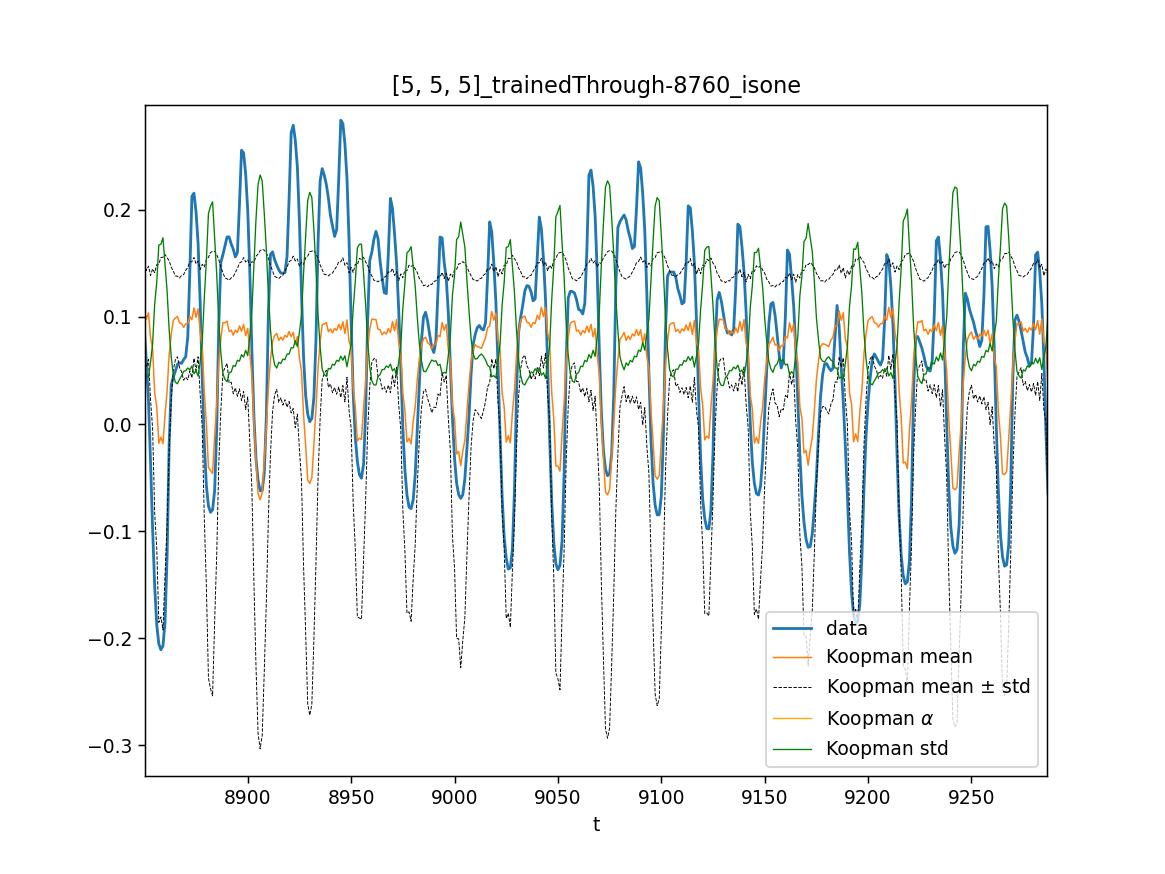

In [10]:
%matplotlib notebook

mean_hat = model.mean(mu_hat, sigma_hat, a_hat)
std_hat = model.std(mu_hat, sigma_hat, a_hat)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=0.8)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    plt.plot(a_hat[:, dim], color="orange", linewidth=0.7, label="Koopman $\\alpha$")
    plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [139]:
k.omegas[7] = 2*np.pi / 5500

In [156]:
mu_hat = np.load("forecasts//energy_data_4mu.npy")
sigma_hat = np.load("forecasts//energy_data_4sigma.npy")

In [23]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [171]:
z_scores = ((x - mu_hat) / sigma_hat)[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [167]:
np.std(z_scores)

1.8403758604065568

<IPython.core.display.Javascript object>


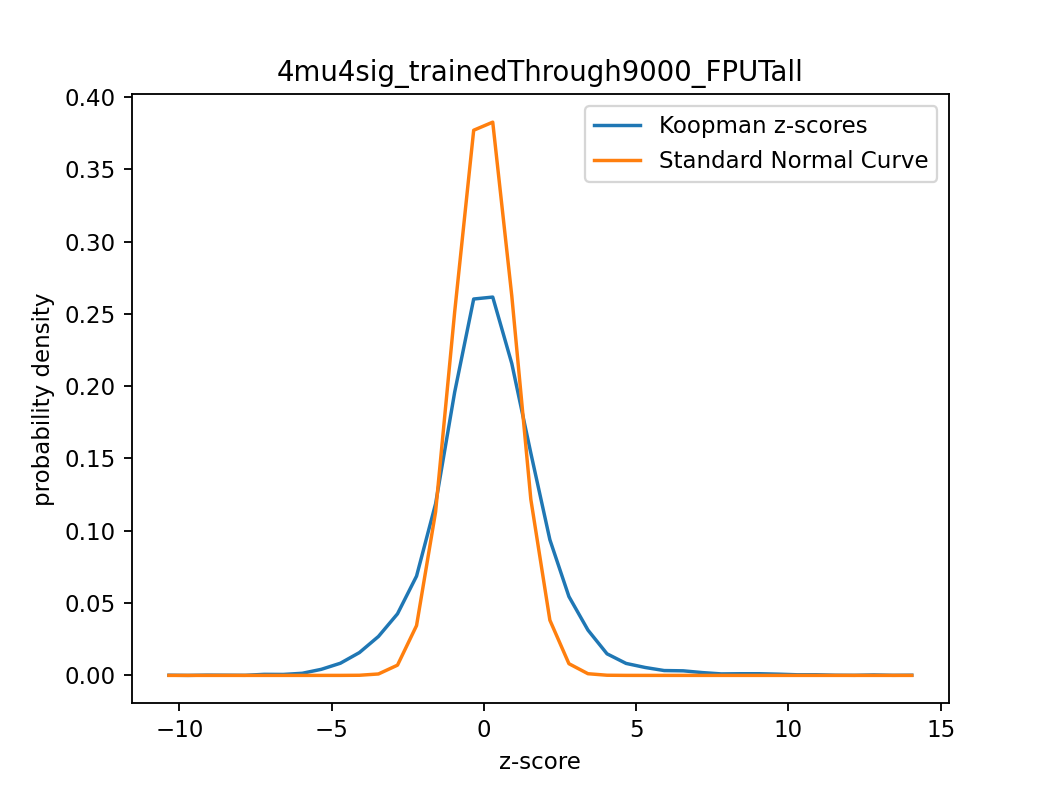

In [172]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_mu}mu{num_sig}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'gf'

In [30]:
def pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q/100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data))

In [35]:
pinball_loss(x_original[-31 * 24:, 0], mu_hat[-31 * 24:, 0] + mean[0], sigma_hat[-31 * 24:, 0] * rnge[0], a_hat[-31 * 24:, 0])

4884.906045327989

In [ ]:
plt.figure()
plt.plot(mu_vec, label="real $\mu$")
plt.plot(mu_hat[:, 0], "--", label="koopman $\mu$")
plt.xlabel("t")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


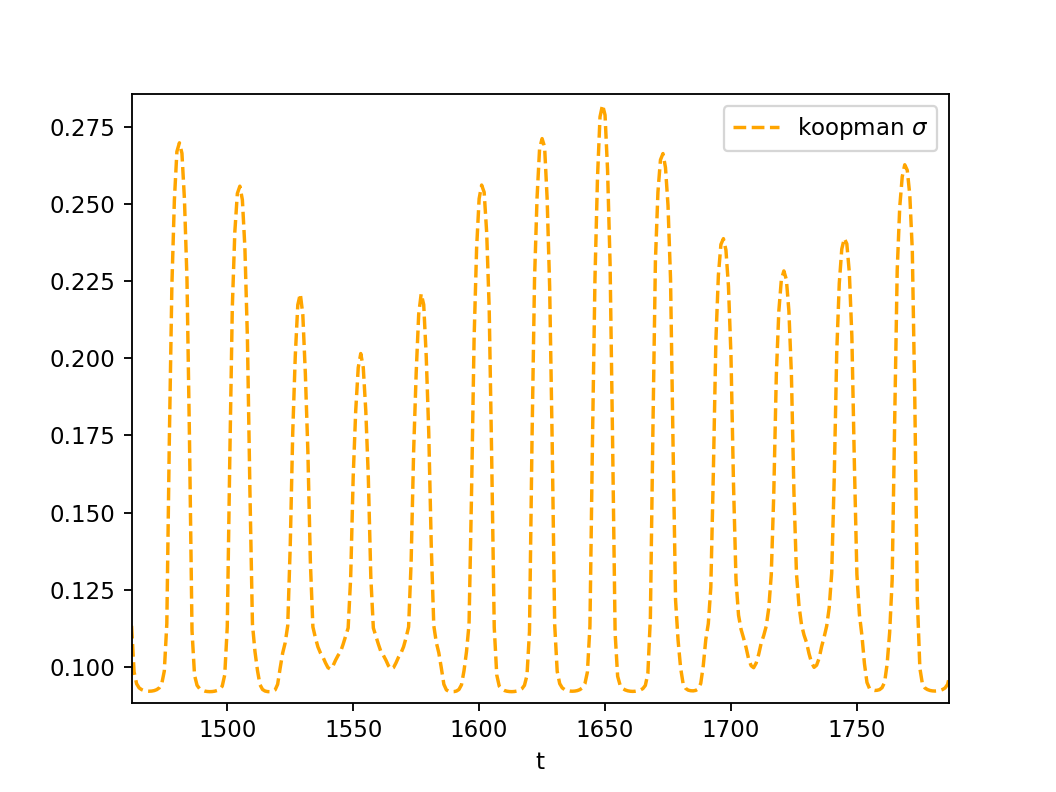

In [13]:
plt.figure()
# plt.plot(sigma_vec, color="blue", label="real $\sigma$")
plt.plot(sigma_hat[:, 0], "--", color="orange", label="koopman $\sigma$")
plt.xlabel("t")
plt.legend()
plt.show()

In [8]:
# Construct pdf quantiles
# REMOVE
# sigma = 1 * np.cos(2 * np.pi / 36 * np.arange(5000) + 1.5) + 4

num_quantiles = 100
domain = [min(mu_hat[:,0] - 2.5*sigma_hat[:, 0]), max(mu_hat[:,0] + 2.5*sigma_hat[:, 0])]
x_axis = np.linspace(domain[0], domain[1], num_quantiles)

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

<IPython.core.display.Javascript object>


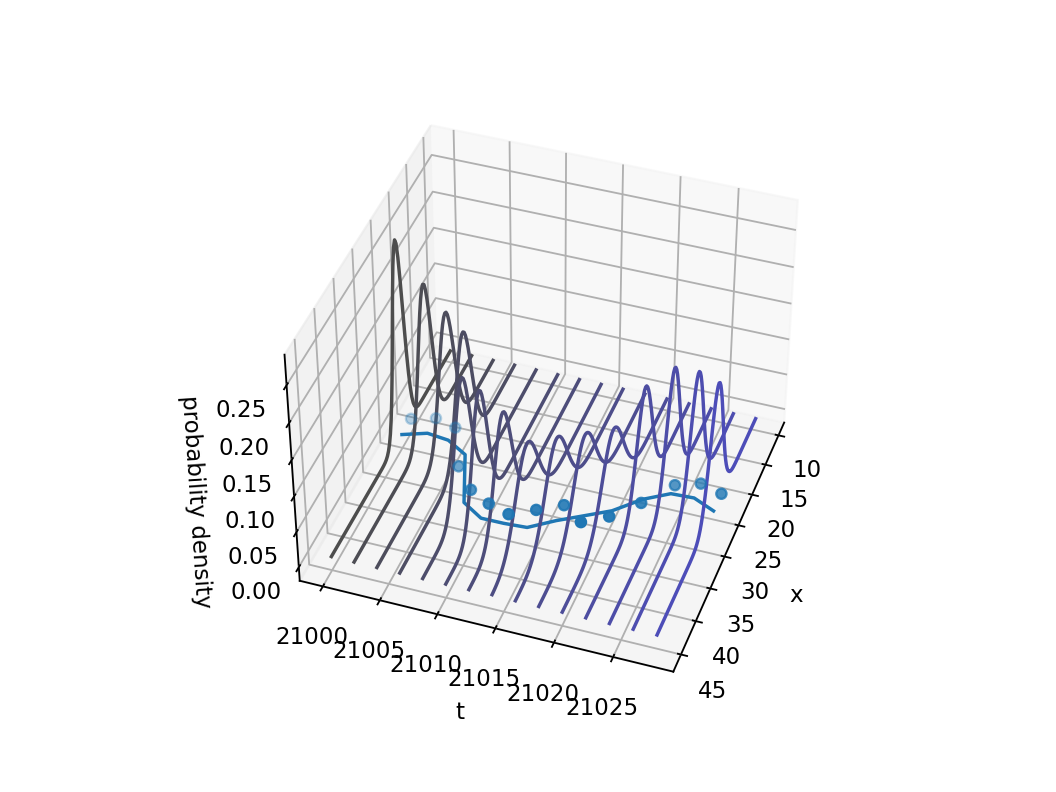

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')

tmin = 21000
tmax = 21030
tstep = 2
ts = range(tmin, tmax, tstep)
plt.plot(mu_hat[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))
ax.scatter(x[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))

for i, t in enumerate(ts):
    z = normal_pdf(mu_hat[t], sigma_hat[t], x_axis)
    plt.plot(x_axis, t*np.ones(num_quantiles), z, color=(0.3, 0.3, 0.3 + 0.03*i))

plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("probability density")


plt.show()

In [6]:
help(np.concatenate)

Help on function concatenate in module numpy:

concatenate(...)
    concatenate((a1, a2, ...), axis=0, out=None)
    
    Join a sequence of arrays along an existing axis.
    
    Parameters
    ----------
    a1, a2, ... : sequence of array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int, optional
        The axis along which the arrays will be joined.  If axis is None,
        arrays are flattened before use.  Default is 0.
    out : ndarray, optional
        If provided, the destination to place the result. The shape must be
        correct, matching that of what concatenate would have returned if no
        out argument were specified.
    
    Returns
    -------
    res : ndarray
        The concatenated array.
    
    See Also
    --------
    ma.concatenate : Concatenate function that preserves input masks.
    array_split : Split an array into multiple sub-arrays of equal or
   